In [2]:
from astropy.io import ascii, fits
import astropy
import pylab as plt
%matplotlib inline
from astropy import wcs
from astropy.table import Table,Column,join,hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import pymoc
import glob
from time import sleep
import os


import numpy as np
import xidplus
from xidplus import moc_routines
import pickle
import xidplus.catalogue as cat

import sys
from herschelhelp_internal.utils import inMoc,flux_to_mag
from xidplus.stan_fit import SPIRE

import aplpy
import seaborn as sns
#sns.set(color_codes=True)
import pandas as pd
#sns.set_style("white")
import xidplus.posterior_maps as postmaps
#from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
import pyvo as vo
import time

In [3]:
lofar = Table.read('data/data_release/final_cross_match_catalogue-v0.5.fits')
mask = (~np.isnan(lofar['F_SPIRE_250'])) | (~np.isnan(lofar['F_SPIRE_350'])) | (~np.isnan(lofar['F_SPIRE_500']))
lofar = lofar[~mask]

print(len(lofar))                  

8370


In [4]:
taskid = 97
batch_size = 20

if taskid*batch_size>len(lofar):
    print('Task id is too high. Trying to run code on more sources than exist')
    sys.exit()
ind_low = taskid*batch_size
if taskid*batch_size+batch_size>len(lofar):
    ind_up = len(lofar)
else:
    ind_up = taskid*batch_size+batch_size
ras = lofar['optRA'][ind_low:ind_up]
mask = np.isnan(ras)
ras[mask] = lofar['RA'][ind_low:ind_up][mask]

decs = lofar['optDec'][ind_low:ind_up]
mask = np.isnan(decs)
decs[mask] = lofar['DEC'][ind_low:ind_up][mask]

ids = lofar['Source_Name'][ind_low:ind_up]

In [5]:
len(ras)

20

In [6]:
source_use = [0,1,2,3,4,5,6,7,8,9]
ras = lofar['optRA'][source_use]
mask = np.isnan(ras)
ras[mask] = lofar['RA'][source_use][mask]

decs = lofar['optDec'][source_use]
mask = np.isnan(decs)
decs[mask] = lofar['DEC'][source_use][mask]

ids = lofar['Source_Name'][source_use]

In [7]:
#Read in the herschel images
imfolder='../../../../../HELP/dmu_products/dmu18/dmu18_ELAIS-N1/data/'

pswfits=imfolder+'ELAIS-N1_SPIRE250_v1.0.fits'#SPIRE 250 map
pmwfits=imfolder+'ELAIS-N1_SPIRE350_v1.0.fits'#SPIRE 350 map


#-----250-------------
hdulist = fits.open(pswfits)
im250phdu=hdulist[0].header
im250hdu=hdulist['image'].header

im250=hdulist['image'].data*1.0E3 #convert to mJy
nim250=hdulist['error'].data*1.0E3 #convert to mJy
w_250 = wcs.WCS(hdulist['image'].header)
#pixsize250=3600.0*w_250.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()
#-----350-------------
hdulist = fits.open(pmwfits)
im350phdu=hdulist[0].header
im350hdu=hdulist['image'].header

im350=hdulist['image'].data*1.0E3 #convert to mJy
nim350=hdulist['error'].data*1.0E3 #convert to mJy
w_350 = wcs.WCS(hdulist['image'].header)
#pixsize350=3600.0*w_350.wcs.cd[1,1] #pixel size (in arcseconds)
hdulist.close()

FileNotFoundError: [Errno 2] No such file or directory: '../../../../../HELP/dmu_products/dmu18/dmu18_ELAIS-N1/data/ELAIS-N1_SPIRE250_v1.0.fits'

In [8]:
imfolder='../../../../../HELP/dmu_products/dmu18/dmu18_ELAIS-N1/data/'

im100fits=imfolder + 'ELAIS-N1-100um-img_wgls.fits'#PACS 100 map
nim100fits=imfolder + 'ELAIS-N1-100um-img_noise.fits'#PACS 100 noise map
im160fits=imfolder + 'ELAIS-N1-160um-img_wgls.fits'#PACS 160 map
nim160fits=imfolder + 'ELAIS-N1-160um-img_noise.fits'#PACS 100 noise map

#-----100-------------
hdulist = fits.open(im100fits)
im100phdu=hdulist[0].header
im100hdu=hdulist[0].header
im100=hdulist[0].data
w_100 = wcs.WCS(hdulist[0].header)
pixsize100=3600.0*np.abs(hdulist[0].header['CDELT1']) #pixel size (in arcseconds)
hdulist.close()

hdulist = fits.open(nim100fits)
nim100=hdulist[0].data
hdulist.close()

#-----160-------------
hdulist = fits.open(im160fits)
im160phdu=hdulist[0].header
im160hdu=hdulist[0].header

im160=hdulist[0].data #convert to mJy
w_160 = wcs.WCS(hdulist[0].header)
pixsize160=3600.0*np.abs(hdulist[0].header['CDELT1']) #pixel size (in arcseconds)
hdulist.close()

hdulist = fits.open(nim160fits)
nim160=hdulist[0].data
hdulist.close()

In [9]:
prior_cat = Table.read('data/data_release/xidplus_prior_cat.fits')

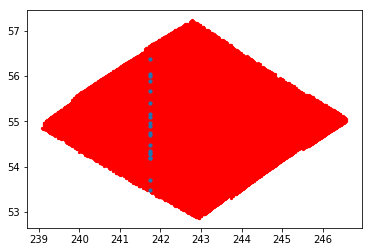

In [12]:
x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=5,color='red')

x = ras
y = decs
plt.scatter(x,y,s=10)

#plt.xlim(np.min(help_masterlist['ra']),np.max(help_masterlist['ra']))
#plt.ylim(np.min(help_masterlist['dec']),np.max(help_masterlist['dec']))
plt.show()

In [10]:
from astropy.coordinates import SkyCoord
from astropy import units as u
c = SkyCoord(ra=ras*u.degree, dec=decs*u.degree)  
import pymoc
moc=pymoc.util.catalog.catalog_to_moc(c,60,15)

In [11]:
mask = inMoc(ras,decs,moc)
np.sum(mask)

10

In [12]:
t1 = time.time()
#---prior100--------
prior100=xidplus.prior(im100,nim100,im100phdu,im100hdu, moc=moc)#Initialise with map, uncertianty map, wcs info and primary header
prior100.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])#Set input catalogue
prior100.prior_bkg(0.0,5)#Set prior on background (assumes Gaussian pdf with mu and sigma)

#---prior160--------
prior160=xidplus.prior(im160,nim160,im160phdu,im160hdu, moc=moc)
prior160.prior_cat(prior_cat['ra'],prior_cat['dec'],'prior_cat',ID=prior_cat['help_id'])
prior160.prior_bkg(0.0,5)
t2 = time.time()
print('time taken is: {}s'.format(t2-t1))

time taken is: 347.3534038066864s


In [13]:
pacs100_psf=fits.open(imfolder+'dmu18_PACS_100_PSF_ELAIS-N1_20170720.fits')
pacs160_psf=fits.open(imfolder+'dmu18_PACS_160_PSF_ELAIS-N1_20170720.fits')

centre100=np.long((pacs100_psf[1].header['NAXIS1']-1)/2)
radius100=15
centre160=np.long((pacs160_psf[1].header['NAXIS1']-1)/2)
radius160=25

pind100=np.arange(0,radius100+1+radius100,1)*3600*np.abs(pacs100_psf[1].header['CDELT1'])/pixsize100 #get 100 scale in terms of pixel scale of map
pind160=np.arange(0,radius160+1+radius160,1)*3600*np.abs(pacs160_psf[1].header['CDELT1'])/pixsize160 #get 160 scale in terms of pixel scale of map

prior100.set_prf(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1]/1000.0,
                pind100,pind100)
prior160.set_prf(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1]/1000.0,
                pind160,pind160)

In [15]:
pind100

array([ 0.        ,  0.33333333,  0.66666667,  1.        ,  1.33333333,
        1.66666667,  2.        ,  2.33333333,  2.66666667,  3.        ,
        3.33333333,  3.66666667,  4.        ,  4.33333333,  4.66666667,
        5.        ,  5.33333333,  5.66666667,  6.        ,  6.33333333,
        6.66666667,  7.        ,  7.33333333,  7.66666667,  8.        ,
        8.33333333,  8.66666667,  9.        ,  9.33333333,  9.66666667,
       10.        ])

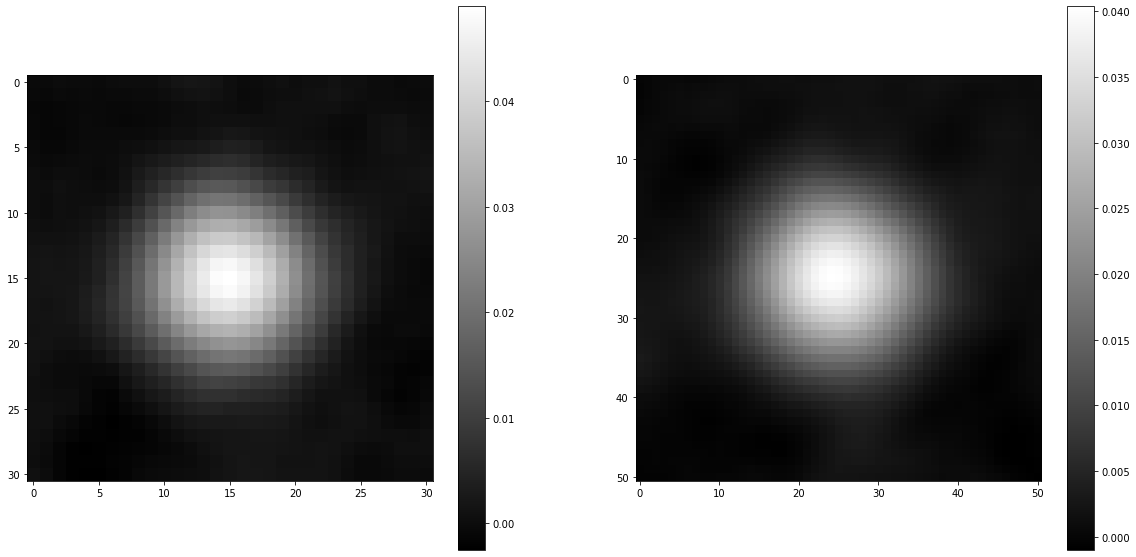

In [18]:
#import pylab as plt
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(pacs100_psf[1].data[centre100-radius100:centre100+radius100+1,centre100-radius100:centre100+radius100+1],cmap='gray')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(pacs160_psf[1].data[centre160-radius160:centre160+radius160+1,centre160-radius160:centre160+radius160+1],cmap='gray')
plt.colorbar()

In [27]:
print('fitting '+ str(prior100.nsrc)+' sources \n')
print('using ' +  str(prior100.snpix)+', '+ str(prior160.snpix))



fitting 25 sources 

using 2820, 1258


In [28]:
prior100.get_pointing_matrix()
prior160.get_pointing_matrix()

In [61]:
prior100.upper_lim_map()
prior160.upper_lim_map()

In [29]:
from xidplus.stan_fit import PACS
t1 = time.time()
fit=PACS.all_bands(prior100,prior160,iter=1000)
t2 = time.time()
print('time taken is: {}s'.format(t2-t1))

/lustre/scratch/astro/im281/FIR-group/Ian/lofar/deep_fields/ELAIS-N1/XID+PACS.pkl
/XID+PACS found. Reusing
time taken is: 368.39608907699585s


In [30]:
posterior=xidplus.posterior_stan(fit,[prior100,prior160])

In [31]:
priors = [prior100,prior160]

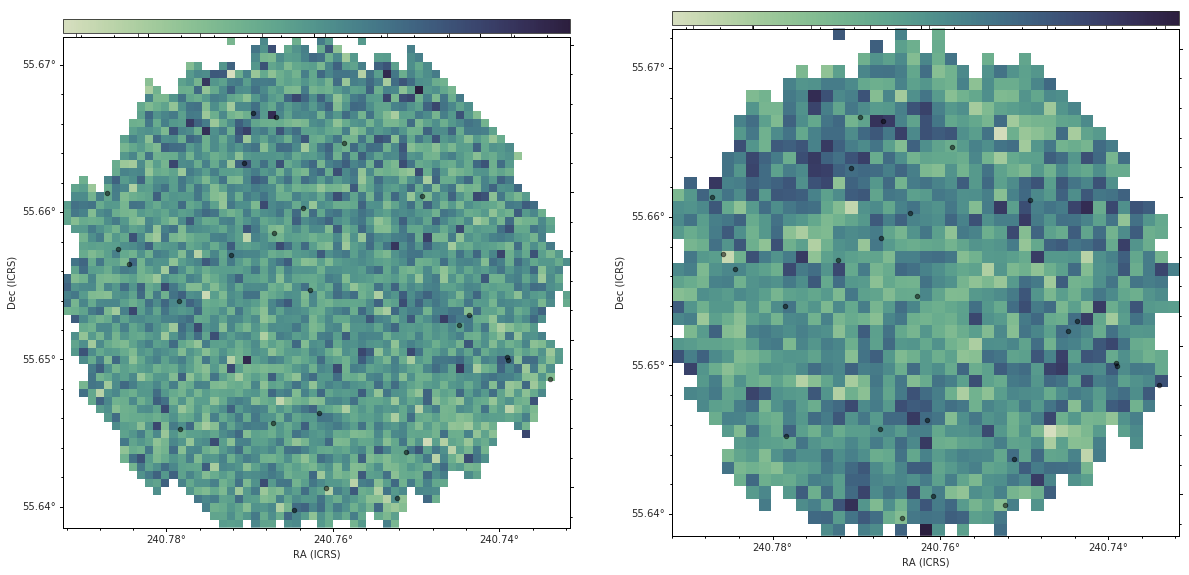

In [32]:
figs,fig=xidplus.plot_map(priors)

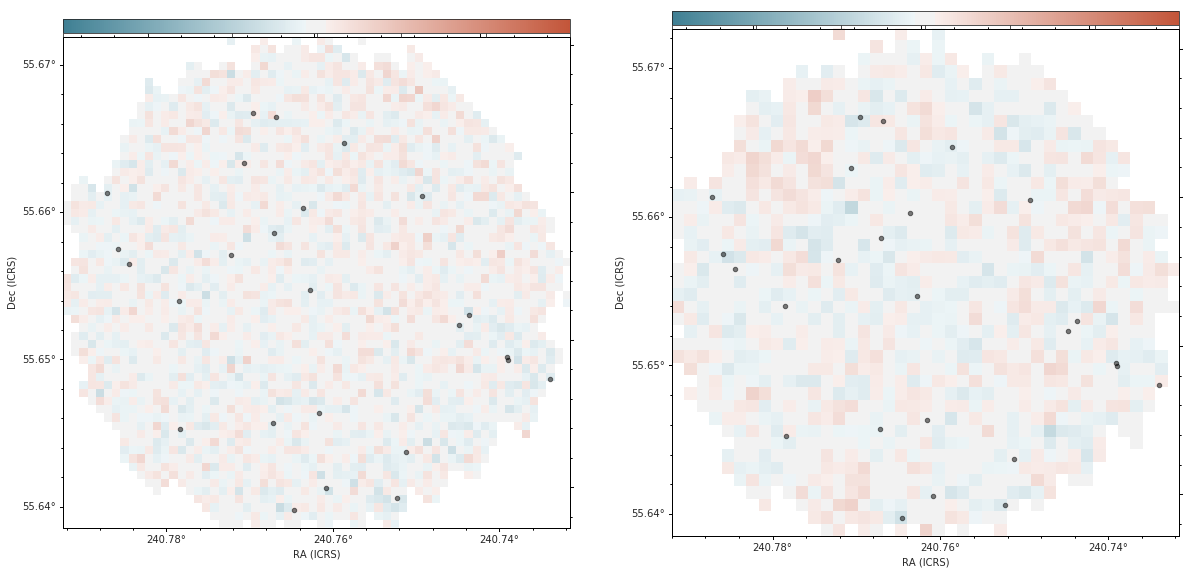

In [33]:
figs, fig=xidplus.plot_Bayes_pval_map(priors, posterior)

In [34]:
import xidplus.catalogue as cat
PACS_cat=cat.create_PACS_cat(posterior,priors[0],priors[1])

In [35]:
PACS_cat = Table.read(PACS_cat)

In [43]:
help_XID = Table.read('data/fir/dmu26_XID+PACS_ELAIS-N1_SWIRE_cat_20170808.fits')
joined = join(PACS_cat,help_XID,join_type='inner',keys='help_id')
len(joined)

21

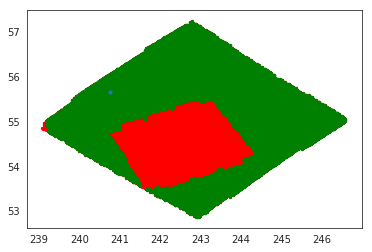

In [44]:
x = prior_cat['ra']
y = prior_cat['dec']
plt.scatter(x,y,s=5,color='red')

x = help_XID['RA']
y = help_XID['Dec']
plt.scatter(x,y,c='green',s=5)

x = ras
y = decs
plt.scatter(x,y,s=10)

#plt.xlim(np.min(help_masterlist['ra']),np.max(help_masterlist['ra']))
#plt.ylim(np.min(help_masterlist['dec']),np.max(help_masterlist['dec']))
plt.show()

In [45]:
joined[0]

help_id,RA_1,Dec_1,F_PACS_100_1,FErr_PACS_100_u_1,FErr_PACS_100_l_1,F_PACS_160_1,FErr_PACS_160_u_1,FErr_PACS_160_l_1,Bkg_PACS_100_1,Bkg_PACS_160_1,Sig_conf_PACS_100_1,Sig_conf_PACS_160_1,Rhat_PACS_100_1,Rhat_PACS_160_1,n_eff_PACS_100_1,n_eff_PACS_160_1,Pval_res_100_1,Pval_res_160_1,RA_2,Dec_2,F_PACS_100_2,FErr_PACS_100_u_2,FErr_PACS_100_l_2,F_PACS_160_2,FErr_PACS_160_u_2,FErr_PACS_160_l_2,Bkg_PACS_100_2,Bkg_PACS_160_2,Sig_conf_PACS_100_2,Sig_conf_PACS_160_2,Rhat_PACS_100_2,Rhat_PACS_160_2,n_eff_PACS_100_2,n_eff_PACS_160_2,Pval_res_100_2,Pval_res_160_2,flag_PACS_100,flag_PACS_160
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,bool
HELP_J160255.976+553850.618,240.73323488297171,55.64739379242802,12.9060545,28.508474,3.7554395,32.78034,63.39444,10.932225,0.00055897946,-0.00029909998,3.5427172e-05,5.958989e-05,0.99996406,1.0006356,2798.0413,2097.216,0.0,0.0,240.73323488297171,55.64739379242802,9.59539,21.184494,2.9141908,20.265789,41.367214,6.517254,0.0006831844,-5.156904e-05,2.3759332e-05,4.117764e-05,1.0000437,1.0003377,2000.0,2000.0,0.0,0.0,True,False


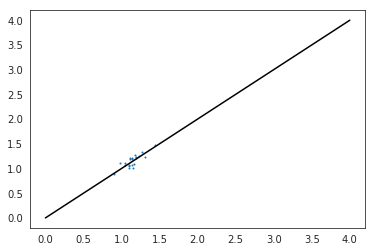

In [46]:
x = np.log10(joined['F_PACS_100_2'])
xerr_u = np.log10(joined['FErr_PACS_100_u_2']-joined['F_PACS_100_2'])
yerr_l = np.log10(joined['F_PACS_100_2']-joined['FErr_PACS_100_l_2'])
y = np.log10(joined['F_PACS_100_1'])
yerr_u = np.log10(joined['FErr_PACS_100_u_1']-joined['F_PACS_100_1'])
yerr_l = np.log10(joined['F_PACS_100_1']-joined['FErr_PACS_100_l_1'])

#plt.errorbar(x,y,xerr=xerr,yerr=[yerr_u,yerr_l],linestyle='')
plt.scatter(x,y,s=1)
plt.plot([0,4],[0,4],c='black')
plt.show()

In [38]:
PACS_cat[0]

help_id,RA,Dec,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160
,degrees,degrees,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,
str27,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
HELP_J160255.976+553850.618,240.73323488297171,55.64739379242802,12.9060545,28.508474,3.7554395,32.78034,63.39444,10.932225,0.00055897946,-0.00029909998,3.5427172e-05,5.958989e-05,0.99996406,1.0006356,2798.0413,2097.216,0.0,0.0


In [ ]:
mask = [PACS_cat['help_id'][i] in ids for i in range(len(PACS_cat))]
#mask2 = ['ILTJ' in ]
PACS_cat[mask]

In [140]:
mask = 'ILTJ' in SPIRE_cat['HELP_ID']
mask_lofar = lofar['ra']==ra
mask_pcat = prior_cat['help_id']=='lofar'
SPIRE_cat = SPIRE_cat[mask]
SPIRE_cat.add_columns([prior_cat['f_mips_24'][mask_pcat],prior_cat['flag_optnir_det'][mask_pcat]])
lofar_fir = hstack([lofar[mask_lofar],SPIRE_cat])
XID_rerun_col = Column(data=XID_rerun,name='XID_rerun',dtype=bool)
source_type_col = Column(data=source_type,name='source_type',dtype=str)
lofar_fir.add_columns([XID_rerun_col,source_type_col])
    
#os.mkdir('testfolder')
#Table.write(lofar_fir,'testfolder/lofar_xidplus_fir.fits')

In [141]:
lofar_fir

Source_id,Isl_id,RA_1,E_RA,DEC,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,RA_max,E_RA_max,DEC_max,E_DEC_max,Maj,E_Maj,Min,E_Min,PA,E_PA,Maj_img_plane,E_Maj_img_plane,Min_img_plane,E_Min_img_plane,PA_img_plane,E_PA_img_plane,DC_Maj,E_DC_Maj,DC_Min,E_DC_Min,DC_PA,E_DC_PA,DC_Maj_img_plane,E_DC_Maj_img_plane,DC_Min_img_plane,E_DC_Min_img_plane,DC_PA_img_plane,E_DC_PA_img_plane,Isl_Total_flux,E_Isl_Total_flux,Isl_rms,Isl_mean,Resid_Isl_rms,Resid_Isl_mean,S_Code,FLAG_OVERLAP_1,lr_fin,lr_dist_fin,lr_index_fin,fworkflow_all,FLAG_WORKFLOW,NUMBER,SNR_WIN,BACKGROUND,THRESHOLD,X_IMAGE,Y_IMAGE,ra,dec,X2_IMAGE,Y2_IMAGE,XY_IMAGE,X2_WORLD,Y2_WORLD,A_IMAGE,B_IMAGE,THETA_IMAGE,ERRA_IMAGE,ERRB_IMAGE,ERRTHETA_IMAGE,FLAGS_i,CLASS_STAR,FLAGS_J,FLAGS_K,FLAGS_g,FLAGS_hscg,FLAGS_hsci,FLAGS_hscnb921,FLAGS_hscr,FLAGS_hscy,FLAGS_hscz,FLAGS_r,FLAGS_se1,FLAGS_se2,FLAGS_sw1,FLAGS_sw2,FLAGS_sw3,FLAGS_sw4,FLAGS_u,FLAGS_y,FLAGS_z,flag_clean,NUMBER_OPTICAL,NUMBER_SPITZER,MAG_APER_sw4_1,MAG_APER_sw4_2,MAG_APER_sw4_3,MAG_APER_sw4_4,MAG_APER_sw4_5,MAG_APER_sw4_6,MAG_APER_sw4_7,MAG_APER_sw4_10,MAGERR_APER_sw4_1,MAGERR_APER_sw4_2,MAGERR_APER_sw4_3,MAGERR_APER_sw4_4,MAGERR_APER_sw4_5,MAGERR_APER_sw4_6,MAGERR_APER_sw4_7,MAGERR_APER_sw4_10,FLUX_APER_sw4_1,FLUX_APER_sw4_2,FLUX_APER_sw4_3,FLUX_APER_sw4_4,FLUX_APER_sw4_5,FLUX_APER_sw4_6,FLUX_APER_sw4_7,FLUX_APER_sw4_10,FLUXERR_APER_sw4_1,FLUXERR_APER_sw4_2,FLUXERR_APER_sw4_3,FLUXERR_APER_sw4_4,FLUXERR_APER_sw4_5,FLUXERR_APER_sw4_6,FLUXERR_APER_sw4_7,FLUXERR_APER_sw4_10,MAG_APER_sw1_1,MAG_APER_sw1_2,MAG_APER_sw1_3,MAG_APER_sw1_4,MAG_APER_sw1_5,MAG_APER_sw1_6,MAG_APER_sw1_7,MAG_APER_sw1_10,MAGERR_APER_sw1_1,MAGERR_APER_sw1_2,MAGERR_APER_sw1_3,MAGERR_APER_sw1_4,MAGERR_APER_sw1_5,MAGERR_APER_sw1_6,MAGERR_APER_sw1_7,MAGERR_APER_sw1_10,FLUX_APER_sw1_1,FLUX_APER_sw1_2,FLUX_APER_sw1_3,FLUX_APER_sw1_4,FLUX_APER_sw1_5,FLUX_APER_sw1_6,FLUX_APER_sw1_7,FLUX_APER_sw1_10,FLUXERR_APER_sw1_1,FLUXERR_APER_sw1_2,FLUXERR_APER_sw1_3,FLUXERR_APER_sw1_4,FLUXERR_APER_sw1_5,FLUXERR_APER_sw1_6,FLUXERR_APER_sw1_7,FLUXERR_APER_sw1_10,MAG_APER_sw3_1,MAG_APER_sw3_2,MAG_APER_sw3_3,MAG_APER_sw3_4,MAG_APER_sw3_5,MAG_APER_sw3_6,MAG_APER_sw3_7,MAG_APER_sw3_10,MAGERR_APER_sw3_1,MAGERR_APER_sw3_2,MAGERR_APER_sw3_3,MAGERR_APER_sw3_4,MAGERR_APER_sw3_5,MAGERR_APER_sw3_6,MAGERR_APER_sw3_7,MAGERR_APER_sw3_10,FLUX_APER_sw3_1,FLUX_APER_sw3_2,FLUX_APER_sw3_3,FLUX_APER_sw3_4,FLUX_APER_sw3_5,FLUX_APER_sw3_6,FLUX_APER_sw3_7,FLUX_APER_sw3_10,FLUXERR_APER_sw3_1,FLUXERR_APER_sw3_2,FLUXERR_APER_sw3_3,FLUXERR_APER_sw3_4,FLUXERR_APER_sw3_5,FLUXERR_APER_sw3_6,FLUXERR_APER_sw3_7,FLUXERR_APER_sw3_10,MAG_APER_sw2_1,MAG_APER_sw2_2,MAG_APER_sw2_3,MAG_APER_sw2_4,MAG_APER_sw2_5,MAG_APER_sw2_6,MAG_APER_sw2_7,MAG_APER_sw2_10,MAGERR_APER_sw2_1,MAGERR_APER_sw2_2,MAGERR_APER_sw2_3,MAGERR_APER_sw2_4,MAGERR_APER_sw2_5,MAGERR_APER_sw2_6,MAGERR_APER_sw2_7,MAGERR_APER_sw2_10,FLUX_APER_sw2_1,FLUX_APER_sw2_2,FLUX_APER_sw2_3,FLUX_APER_sw2_4,FLUX_APER_sw2_5,FLUX_APER_sw2_6,FLUX_APER_sw2_7,FLUX_APER_sw2_10,FLUXERR_APER_sw2_1,FLUXERR_APER_sw2_2,FLUXERR_APER_sw2_3,FLUXERR_APER_sw2_4,FLUXERR_APER_sw2_5,FLUXERR_APER_sw2_6,FLUXERR_APER_sw2_7,FLUXERR_APER_sw2_10,MAG_APER_se2_1,MAG_APER_se2_2,MAG_APER_se2_3,MAG_APER_se2_4,MAG_APER_se2_5,MAG_APER_se2_6,MAG_APER_se2_7,MAG_APER_se2_10,MAGERR_APER_se2_1,MAGERR_APER_se2_2,MAGERR_APER_se2_3,MAGERR_APER_se2_4,MAGERR_APER_se2_5,MAGERR_APER_se2_6,MAGERR_APER_se2_7,MAGERR_APER_se2_10,FLUX_APER_se2_1,FLUX_APER_se2_2,FLUX_APER_se2_3,FLUX_APER_se2_4,FLUX_APER_se2_5,FLUX_APER_se2_6,FLUX_APER_se2_7,FLUX_APER_se2_10,FLUXERR_APER_se2_1,FLUXERR_APER_se2_2,FLUXERR_APER_se2_3,FLUXERR_APER_se2_4,FLUXERR_APER_se2_5,FLUXERR_APER_se2_6,FLUXERR_APER_se2_7,FLUXERR_APER_se2_10,MAG_APER_se1_1,MAG_APER_se1_2,MAG_APER_se1_3,MAG_APER_se1_4,MAG_APER_se1_5,MAG_APER_se1_6,MAG_APER_se1_7,MAG_APER_se1_10,MAGERR_APER_se1_1,MAGERR_APER_se1_2,MAGERR_APER_se1_3,MAGERR_APER_se1_4,MAGERR_APER_se1_5,MAGERR_APER_se1_6,MAGERR_APER_se1_7,MAGERR_APER_se1_10,FLUX_APER_se1_1,FLUX_APER_se1_2,FL

In [147]:
os.path.exists('data/fir_v2/xidplus_run_3')

True

In [9]:
len(lofar)

32833